# VictoriaMetrics query example

In [159]:
import os
import datetime

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline
from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.dates as mdates

from tqdm.notebook import trange, tqdm

import caput.time
from ch_ephem.observers import chime
import prym

In [9]:
# Get default matplotlib color cycle, so that we can repeat colors easily in plots
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# Set reasonable font sizes for plots
plt.rc("font", **{"size": "10"})#, "family": "serif", "serif": ["CMU serif"]})
plt.rcParams.update({'figure.figsize': (10, 7)})

In [122]:
# Define shortcut for CSD-to-unixtime routine
csd_to_unix = chime.lsd_to_unix

## Querying VictoriaMetrics for FFT overflow flags

In [123]:
# Set VictoriaMetrics client
client = prym.Prometheus("http://bao.chimenet.ca:3308")

In [124]:
# Set query name (for FFT overflows from crate 0)
query = ("fpga_fft_overflow_count{crate_number=~'0'}")

In [125]:
# Set time range to query (corresponding to CSD 1878)
csd = 1878
end = caput.time.unix_to_datetime(csd_to_unix(csd+1))
start = caput.time.unix_to_datetime(csd_to_unix(csd))

In [138]:
# Execute query. 3s seems to be the smallest interval for which we can query an entire day
# without getting an error
data, labels, times = client.query_range(query, start, end, "3s", pandas=False)

In [139]:
# data: a numpy array of the results
print(data, data.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] (256, 28722)


In [142]:
# labels: labels for each input (only print a few as examples)
for i in range(3):
    print(labels[i])
print(len(labels))

{'__name__': 'fpga_fft_overflow_count', 'chan': '12', 'crate_id': 'MGK7BP16_SN021', 'crate_number': '0', 'id': 'MGK7MB_SN0307', 'instance': 'carillon:54321', 'job': 'fpga', 'origin': 'hk-east', 'slot': '14'}
{'__name__': 'fpga_fft_overflow_count', 'chan': '14', 'crate_id': 'MGK7BP16_SN021', 'crate_number': '0', 'id': 'MGK7MB_SN0253', 'instance': 'carillon:54321', 'job': 'fpga', 'origin': 'hk-east', 'slot': '0'}
{'__name__': 'fpga_fft_overflow_count', 'chan': '14', 'crate_id': 'MGK7BP16_SN021', 'crate_number': '0', 'id': 'MGK7MB_SN0250', 'instance': 'carillon:54321', 'job': 'fpga', 'origin': 'hk-east', 'slot': '6'}
256


In [144]:
# times: Unix timestamps for outputs
print(times, times.shape)

[1.54630547e+09 1.54630547e+09 1.54630547e+09 ... 1.54639163e+09
 1.54639163e+09 1.54639163e+09] (28722,)


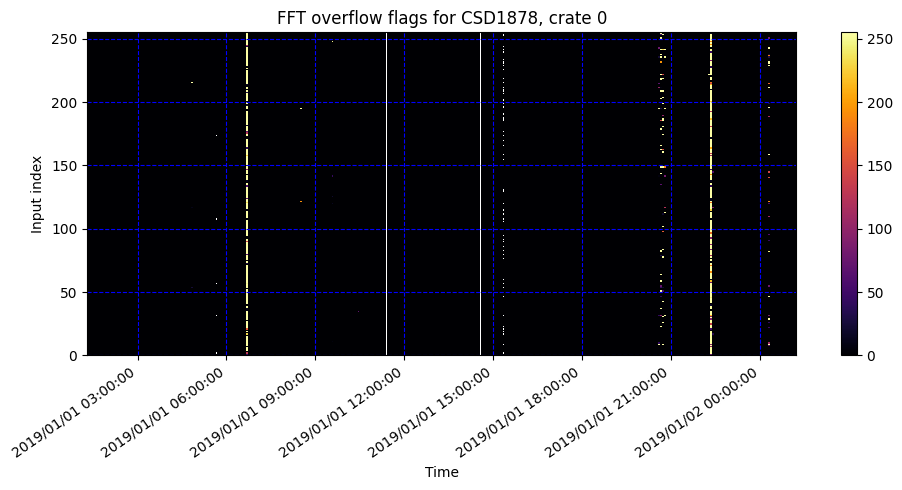

In [177]:
# Visualize flags
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
im = ax.imshow(
    data, 
    origin='lower', 
    aspect='auto', 
    interpolation='none', 
    cmap='inferno', 
    extent=(caput.time.unix_to_datetime(times[0]), caput.time.unix_to_datetime(times[-1]), 0, len(labels)-1)
)

date_format = mdates.DateFormatter("%Y/%m/%d %H:%M:%S")
ax.xaxis.set_major_formatter(date_format)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=35, ha='right')

fig.colorbar(im, ax=ax, orientation='vertical')
ax.grid(ls='--', c='blue')

ax.set_xlabel("Time")
ax.set_ylabel("Input index")
ax.set_title(f"FFT overflow flags for CSD{csd}, crate 0")

plt.tight_layout()